## Bulk STAC item queries with GeoParquet

In addition to its [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/), the Planetary Computer also provides acess to STAC items as [geoparquet datasets](https://github.com/opengeospatial/geoparquet). These parquet datasets can be used for "bulk" workloads, where the search might return a very large number of items, or if it might require many separate queries to get your desired result. In general, these parquet datasets are produced with a lag relative to what's available through the STAC API. Most use-cases, including those that need recently added assets, should use our [STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/).

This example shows how to load STAC items from a Parquet datset into a [geopandas](https://geopandas.readthedocs.io/) GeoDataFrame. A similar workflow would be possible with R's [geoarrow](https://wcjochem.github.io/sfarrow/index.html) package, or any other library that can read [GeoParquet](https://github.com/opengeospatial/geoparquet#current-implementations--examples).

In [1]:
import dask.dataframe as dd
import geopandas
import planetary_computer
import pystac_client
import pandas as pd

pd.options.display.max_columns = 8

### Loading STAC Items

Each STAC collection providing a geoparquet dataset has a collection-level asset under the `geoparquet-items` key.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)
collection = catalog.get_collection("io-lulc-9-class")

asset = planetary_computer.sign(collection.assets["geoparquet-items"])

df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df.head()

,type,stac_version,stac_extensions,id,...,end_datetime,proj:transform,start_datetime,io:supercell_id
0,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,05L-2017,...,2018-01-01 00:00:00+00:00,"[10.0, 0.0, 169260.0, 0.0, -10.0, 9115700.0]",2017-01-01 00:00:00+00:00,05L
1,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,05M-2017,...,2018-01-01 00:00:00+00:00,"[10.0, 0.0, 166024.76778650173, 0.0, -10.0, 99...",2017-01-01 00:00:00+00:00,05M
2,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,05Q-2017,...,2018-01-01 00:00:00+00:00,"[10.0, 0.0, 178900.28857004497, 0.0, -10.0, 26...",2017-01-01 00:00:00+00:00,05Q
3,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,12Q-2017,...,2018-01-01 00:00:00+00:00,"[10.0, 0.0, 178910.0, 0.0, -10.0, 2657470.0]",2017-01-01 00:00:00+00:00,12Q
4,Feature,1.0.0,[https://stac-extensions.github.io/projection/...,16M-2017,...,2018-01-01 00:00:00+00:00,"[10.0, 0.0, 166023.6435927535, 0.0, -10.0, 999...",2017-01-01 00:00:00+00:00,16M


Now we can do things like look at the count of each `proj:epsg` code.

In [3]:
df["proj:epsg"].value_counts()

32616    50
32719    50
32638    50
32649    50
32615    50
         ..
32726     9
32710     9
32708     8
32727     5
32711     5
Name: proj:epsg, Length: 120, dtype: int64

Or filter the items to a specific code and plot the footprints.

In [4]:
subset = df.loc[df["proj:epsg"] == 32651, ["io:tile_id", "geometry"]]

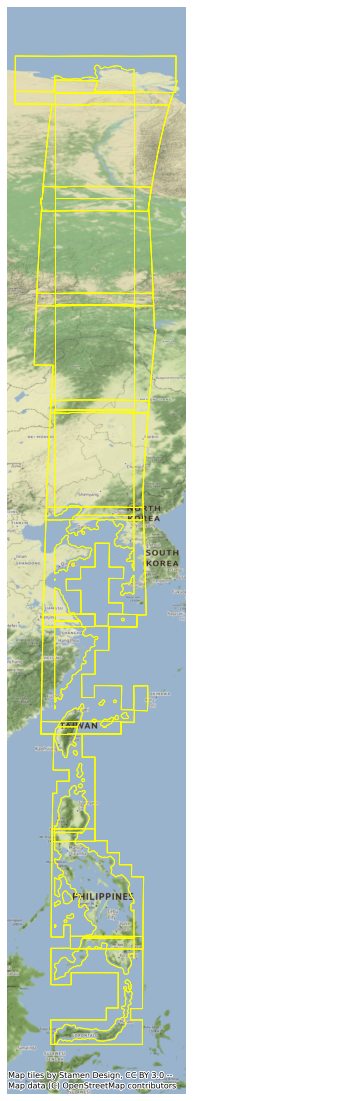

In [5]:
import contextily

ax = subset.plot(figsize=(4, 20), color="none", edgecolor="yellow")
contextily.add_basemap(ax, crs=df.crs.to_string())

ax.set_axis_off()

### Schemas

Each parquet dataset has a unique schema, reflecting the unique properties captured in each collection. But there are some general patterns.

1. Each dataset has a column for the properties required on a STAC item (`type`, `stac_version`, `stac_extensions`, `id`, `geometry`, `bbox`, `links`, `assets`, and `collection`).
2. All fields under `properties` are lifted to the top-level, including datetime-related fields like `datetime`, `start_datetime`, `end_datetime`, common metadata (e.g. `platform`) and extension fields (e.g. `proj:bbox`, ...).
3. Dynamic datasets, where new items are regularly added, are partitioned by time. 

### Partitioning

Depending on the number of STAC items in the collection and whether or not new items are being added, the Parquet dataset may be split into multiple files by time.

For example, the `io-lulc-9-class` collection is not partitioned and has just a single file:

In [6]:
import adlfs

fs = adlfs.AzureBlobFileSystem(**asset.extra_fields["table:storage_options"])
fs.ls("items/io-lulc-9-class.parquet")  # Not partitioned, single result

['items/io-lulc-9-class.parquet']

Compare that to `sentintel-2-l2a`, which is partitioned by week.

In [7]:
fs.ls("items/sentinel-2-l2a.parquet")[:5]

['items/sentinel-2-l2a.parquet/part-0000_2015-06-29T10:25:31+00:00_2015-07-06T10:25:31+00:00.parquet',
 'items/sentinel-2-l2a.parquet/part-0001_2015-07-06T10:25:31+00:00_2015-07-13T10:25:31+00:00.parquet',
 'items/sentinel-2-l2a.parquet/part-0002_2015-07-13T10:25:31+00:00_2015-07-20T10:25:31+00:00.parquet',
 'items/sentinel-2-l2a.parquet/part-0003_2015-07-20T10:25:31+00:00_2015-07-27T10:25:31+00:00.parquet',
 'items/sentinel-2-l2a.parquet/part-0004_2015-07-27T10:25:31+00:00_2015-08-03T10:25:31+00:00.parquet']

To work with a partitioned dataset, you can use a library like dask or dask-geopandas.

In [8]:
collection = catalog.get_collection("sentinel-2-l2a")
asset = planetary_computer.sign(collection.assets["geoparquet-items"])

s2l2a = dd.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
s2l2a.head()

,type,stac_version,stac_extensions,id,...,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
0,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T35XQA_2021041...,...,92.546540,0.967449,4.807670,0.0
1,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T32TMM_2021041...,...,0.048035,0.967449,0.051376,0.0
2,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T32TMN_2021041...,...,0.011238,0.967449,0.022928,0.0
3,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T36WWC_2021041...,...,65.812266,0.967449,19.050561,0.0
4,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T36WWD_2021041...,...,97.629422,0.967449,1.861097,0.0


You can perform filtering operations on the entire collection.

In [9]:
mask = (s2l2a["eo:cloud_cover"] < 10) & (s2l2a["s2:nodata_pixel_percentage"] > 90)
keep = s2l2a[mask]
keep.head()

,type,stac_version,stac_extensions,id,...,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
27,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T32RMS_2021041...,...,0.000000,0.967449,0.000000,0.0
56,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T31PFP_2021041...,...,2.169701,0.967449,1.014810,0.0
68,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T31QGU_2021041...,...,0.211487,0.967449,0.171659,0.0
77,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T31SGT_2021041...,...,1.710171,0.967449,1.712733,0.0
80,Feature,1.0.0,[https://stac-extensions.github.io/eo/v1.0.0/s...,S2A_MSIL2A_20150704T101006_R022_T31QHC_2021041...,...,0.000000,0.967449,0.000000,0.0


When you compute the results, the computation will run in parallel. See [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more. As mentioned earlier, the different collections have different properties, and so have different columns in the DataFrame.

In [11]:
s2l2a.columns.tolist()

['type',
 'stac_version',
 'stac_extensions',
 'id',
 'geometry',
 'bbox',
 'links',
 'assets',
 'collection',
 'datetime',
 'platform',
 'proj:epsg',
 'instruments',
 's2:mgrs_tile',
 'constellation',
 's2:granule_id',
 'eo:cloud_cover',
 's2:datatake_id',
 's2:product_uri',
 's2:datastrip_id',
 's2:product_type',
 'sat:orbit_state',
 's2:datatake_type',
 's2:generation_time',
 'sat:relative_orbit',
 's2:water_percentage',
 's2:mean_solar_zenith',
 's2:mean_solar_azimuth',
 's2:processing_baseline',
 's2:snow_ice_percentage',
 's2:vegetation_percentage',
 's2:thin_cirrus_percentage',
 's2:cloud_shadow_percentage',
 's2:nodata_pixel_percentage',
 's2:unclassified_percentage',
 's2:dark_features_percentage',
 's2:not_vegetated_percentage',
 's2:degraded_msi_data_percentage',
 's2:high_proba_clouds_percentage',
 's2:reflectance_conversion_factor',
 's2:medium_proba_clouds_percentage',
 's2:saturated_defective_pixel_percentage']

Different collections will be partitioned by different frequencies, depending on the update cadence, number of STAC items, and size of each STAC item. Look for an `msft:partition_info` property on the asset to check if the dataset is partitioned. The `partition_frequency` is a [pandas Offset alias](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [12]:
asset.extra_fields["msft:partition_info"]

{'is_partitioned': True, 'partition_frequency': 'W-MON'}

### Expanding nested fields

STAC items are highly nested data structures, while libraries like pandas were mostly designed for working with non-nested data types. Consider a column like `assets`, which is a dictionary mapping asset keys to asset objects (which include an `href` and other properties).

In [13]:
df["assets"].head()

0    {'data': {'file:size': 53437205, 'file:values'...
1    {'data': {'file:size': 53622304, 'file:values'...
2    {'data': {'file:size': 55015984, 'file:values'...
3    {'data': {'file:size': 53208880, 'file:values'...
4    {'data': {'file:size': 53981476, 'file:values'...
Name: assets, dtype: object

The [json_normalize](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html) method can be used to expand this single column of nested data into many columns, one per asset:

In [14]:
import pandas as pd

assets = pd.json_normalize(df["assets"].head())
assets

,data.file:size,data.file:values,data.href,data.raster:bands,...,tilejson.href,tilejson.roles,tilejson.title,tilejson.type
0,53437205,"[{'summary': 'No Data', 'values': [0]}, {'summ...",https://ai4edataeuwest.blob.core.windows.net/i...,"[{'nodata': 0, 'spatial_resolution': 10}]",...,https://planetarycomputer.microsoft.com/api/da...,[tiles],TileJSON with default rendering,application/json
1,53622304,"[{'summary': 'No Data', 'values': [0]}, {'summ...",https://ai4edataeuwest.blob.core.windows.net/i...,"[{'nodata': 0, 'spatial_resolution': 10}]",...,https://planetarycomputer.microsoft.com/api/da...,[tiles],TileJSON with default rendering,application/json
2,55015984,"[{'summary': 'No Data', 'values': [0]}, {'summ...",https://ai4edataeuwest.blob.core.windows.net/i...,"[{'nodata': 0, 'spatial_resolution': 10}]",...,https://planetarycomputer.microsoft.com/api/da...,[tiles],TileJSON with default rendering,application/json
3,53208880,"[{'summary': 'No Data', 'values': [0]}, {'summ...",https://ai4edataeuwest.blob.core.windows.net/i...,"[{'nodata': 0, 'spatial_resolution': 10}]",...,https://planetarycomputer.microsoft.com/api/da...,[tiles],TileJSON with default rendering,application/json
4,53981476,"[{'summary': 'No Data', 'values': [0]}, {'summ...",https://ai4edataeuwest.blob.core.windows.net/i...,"[{'nodata': 0, 'spatial_resolution': 10}]",...,https://planetarycomputer.microsoft.com/api/da...,[tiles],TileJSON with default rendering,application/json


And the [explode](https://pandas.pydata.org/docs/reference/api/pandas.Series.explode.html) method will transform each element of a list-like value to a row:

In [15]:
assets["data.file:values"]

0    [{'summary': 'No Data', 'values': [0]}, {'summ...
1    [{'summary': 'No Data', 'values': [0]}, {'summ...
2    [{'summary': 'No Data', 'values': [0]}, {'summ...
3    [{'summary': 'No Data', 'values': [0]}, {'summ...
4    [{'summary': 'No Data', 'values': [0]}, {'summ...
Name: data.file:values, dtype: object

In [16]:
assets["data.file:values"].explode()

0               {'summary': 'No Data', 'values': [0]}
0                 {'summary': 'Water', 'values': [1]}
0                 {'summary': 'Trees', 'values': [2]}
0    {'summary': 'Flooded vegetation', 'values': [4]}
0                 {'summary': 'Crops', 'values': [5]}
0            {'summary': 'Built area', 'values': [7]}
0           {'summary': 'Bare ground', 'values': [8]}
0              {'summary': 'Snow/ice', 'values': [9]}
0               {'summary': 'Clouds', 'values': [10]}
0            {'summary': 'Rangeland', 'values': [11]}
1               {'summary': 'No Data', 'values': [0]}
1                 {'summary': 'Water', 'values': [1]}
1                 {'summary': 'Trees', 'values': [2]}
1    {'summary': 'Flooded vegetation', 'values': [4]}
1                 {'summary': 'Crops', 'values': [5]}
1            {'summary': 'Built area', 'values': [7]}
1           {'summary': 'Bare ground', 'values': [8]}
1              {'summary': 'Snow/ice', 'values': [9]}
1               {'summary': 